# CIS 5450 Group Project
By Alberto Gaytan, Jacob Zimmerman, and Jingxian Qiu <br>
15 December 2022

### Setup
Please copy "entire_brand_df.csv" to your general "My Drive" (not within a folder), and make sure it maintains its name: https://drive.google.com/file/d/1--CA88tj8XvEnb-BAZmbkkF_7xwu2Aya/view?usp=sharing



We are using a Kaggle dataset.

To get the data in here:
1. Go to this [Kaggle link](https://www.kaggle.com) and create a Kaggle account (unless you already have an account)
2. Go to Account and click on "Create New API Token" to get the API key in the form of a json file `kaggle.json`
3. Upload the `kaggle.json` file to the default location in your Google Drive (Don't upload the json file into any _specific_ folder.).

### Motivation: Predicting Nutrition Scores from Open Food Facts Data
With rates of health related issues stemming from a poor diet increasing in recent times, awareness of the need to place greater importance on nutrition has followed. The Open Food Facts database, being open to the public, is likely to be a primary candidate for those looking to analyze what foods they should maintain in their diet and which to cut out. The primary goal of this notebook is to uncover insights about the nutritional value of a product based on its characteristics and to figure out the best way to predict a new product's nutrition score given that we have certain (Open-Food-Facts-like) features about the new product.

Note, we use the nutritional scores provided in the dataset as our measure of nutritional value. A higher nutrition score means less healthy (officially, it means the product has "less nutritional quality," but we use "healthy" and "higher nutritional quality" interchangeably throughout this analysis, which we believe is a reasonable assumption to make). The score ranges from -15 to 40. Learn more here: https://get.apicbase.com/nutri-score-science-based-nutritional-value-labelling-system/


In [ ]:
!pip install pandasql
!pip3 install py_stringsimjoin

import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
from lxml import etree
import urllib
import urllib.request
import seaborn as sns
import py_stringsimjoin as ssj
import py_stringmatching as sm
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, Ridge, LassoCV, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
import pandasql as ps #SQL on Pandas Dataframe
import altair as alt
alt.data_transformers.disable_max_rows()

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26787 sha256=28443abb3ebb5aa41316736cd60cf87be3e84178f97080867e35837969550190
  Stored in directory: /root/.cache/pip/wheels/ed/8f/46/a383923333728744f01ba24adbd8e364f2cb9470a8b8e5b9ff
Successfully built pandasql
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.2 MB/s 
     |████████████████████████████████| 661 kB 49.0 MB/s 
  Created wheel for py-stringsimjoin: filename=py_stringsimjoin-0.3.2-cp38-cp38-linux_x86_64.whl size=4117926 sha256=4c2ec0f5e7501df02e912367d943d245475b75822bba9c2c0eb75e09eedc547f
  Stored in directory: /root/.cache/pip/wheels/7f/61/96/0aa1d87a2d0a9329ea415ffaf74c875c9344434844177f2b62
  Created wheel for py-stringmatching: filename=py_stringmatching-0.4.2-cp38-cp38-linux_x86_64.whl size=21919

DataTransformerRegistry.enable('default')

In [ ]:
!apt update

Ign:1 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://ppa.launchpad.net

In [ ]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Create the kaggle directory and read the uploaded kaggle.json file
# (NOTE: Do NOT run this cell more than once unless restarting kernel)
!mkdir ~/.kaggle

In [ ]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
# Download dataset
!kaggle datasets download -d openfoodfacts/world-food-facts

 95% 103M/109M [00:01<00:00, 171MB/s] 
100% 109M/109M [00:01<00:00, 104MB/s]


In [ ]:
# Unzip folder in Colab content folder
!unzip /content/world-food-facts

Archive:  /content/world-food-facts.zip
  inflating: en.openfoodfacts.org.products.tsv  


In [ ]:
# Read the csv file and save it to a dataframe called `df_airbnb`
ff_df = pd.read_csv("en.openfoodfacts.org.products.tsv", sep='\t', low_memory=False)
ff_df.head(3)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-en.openfoodfacts.org/product/0000000003087/farine-de-ble-noir-ferme-t-y-r-nao,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-en.openfoodfacts.org/product/0000000004530/banana-chips-sweetened-whole,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-en.openfoodfacts.org/product/0000000004559/peanuts-torn-glasser,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN


In [ ]:
# CHECKING DIFFERENCE BETWEEN UK AND FRANCE NUTRITION SCORES
is_same = ff_df.dropna(subset=['nutrition-score-uk_100g', 'nutrition-score-fr_100g'])
is_same = is_same['nutrition-score-uk_100g'] == is_same['nutrition-score-fr_100g']
# print(len(is_same))

count=0
for entry in is_same:
  if entry == True:
    count += 1
# print(count)
print("UK and France versions of nutrition scores are the same: " + str(100 * count / len(is_same)) + "% of the time")

UK and France versions of nutrition scores are the same: 94.87436042314091% of the time


# Cleaning the Data

In [ ]:
# Check the basic information of the dataframe
ff_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356027 entries, 0 to 356026
Columns: 163 entries, code to water-hardness_100g
dtypes: float64(107), object(56)
memory usage: 442.8+ MB


## Dropping Columns with a Significant Amount of Nulls
Most of the 163 columns in this dataset have a significant amount of nulls. Here I drop columns with more than 30% nulls.

In [ ]:
# Drop columns with more than 30% nulls
perc = 30.0 # max percent of null values we are allowing
min_count =  int(((100-perc)/100)*ff_df.shape[0] + 1)
ff_df = ff_df.dropna( axis=1, thresh=min_count)

## Dropping Unnecessary Columns

Next, I drop many columns because they will not add information to our analysis or are a close duplicate of another column. I provide reasoning for dropped columns below where it is not obvious:
*   'creator' is the organization that created the entry
*   'created_t', 'created_datetime', 'last_modified_t', and 'last_modified_datetime' all have to do with when the row entry was created.
*   The 'brands' column is the same as the 'brands_tags' column just with different formatting. Removed 'brands_tags'.
*   'countries' and 'countries_tags' is the same as 'countries_en' with different formatting.
*   'additives' is similar to 'ingredients_text' with different formatting. Note there is a number of additives column that we didn't drop.
*   'ingredients_from_palm_oil_n' and 'ingredients_that_may_be_from_palm_oil_n' is almost always 0 and, upon inspection, is usually not accurate according to the ingredients column (many times the ingredients has palm oil but is not reflected in the 'ingredients_from_palm_oil_n' or the 'ingredients_that_may_be_from_palm_oil_n' columns.
*   The 'states' columns have to do with what information still needs to be added to a respective entry.

In [ ]:
# Drop unnecssary columns
ff_df = ff_df.reset_index().drop(columns=['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 
                            'last_modified_datetime', 'brands_tags', 'countries', 'countries_tags', 'additives', 
                            'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'states',
                            'states_tags', 'states_en'])

Let's see what columns are left.

In [ ]:
# Check again the updated dataframe
print("Open Food Facts Dataframe columns this far: ")
print(ff_df.columns)

Open Food Facts Dataframe columns this far: 
Index(['index', 'product_name', 'brands', 'countries_en', 'ingredients_text',
       'additives_n', 'nutrition_grade_fr', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g'],
      dtype='object')


Rename some columns for easier reading.

In [ ]:
# Dataframe renaming
ff_df = ff_df.rename(columns={'countries_en':'countries', 'nutrition-score-fr_100g':'nutrition_score', 'nutrition-score-uk_100g':'nutrition_score_uk',
                              'brand-tags':'brand','nutrition_grade_fr':'nutrition_grade', 'ingredients_text':'ingredients',
                              'energy_100g':'energy', 'fat_100g':'fat', 'saturated-fat_100g':'saturated_fat', 'carbohydrates_100g':'carbohydrates', 
                              'sugars_100g':'sugars','proteins_100g':'proteins', 'salt_100g':'salt', 'sodium_100g':'sodium'})

## Cleaning 'countries' and 'brands' Columns
We will be exploring the 'countries' and 'brands' columns later. The 'countries' column specificies the country in which the product is available in English, and the 'brands' column denotes the comapny that made the product. However, these columns sometimes have multiple values represented as comma-separated strings. Let's change these columns to hold lists instead of strings (including the rows with only one value).

However, we need to do some extra cleaning for 'brands'. We have to take out leading spaces because this column is comma-space-separeated. Also, some of the names are just "nan" denoting null. So, we have to make these null.

In [ ]:
# Process rows with 'nan' brands
def take_out_string_nans(brands_list):
  for i, brand in enumerate(brands_list):
    if brand == 'nan':
      brands_list[i] = None
  return brands_list

# Str2List for column countries and brands
ff_df['countries'] = ff_df['countries'].apply(lambda countries_str: str(countries_str).split(','))
ff_df['brands'] = ff_df['brands'].apply(lambda brands_str: [brand.strip().strip("\"") for brand in str(brands_str).split(',')])
ff_df['brands'] = ff_df['brands'].apply(lambda brands_list: take_out_string_nans(brands_list))

Quick check:

In [ ]:
## Check again the updated dataframe

print("Couple entries with multiple values in the 'countries' column to validate our work: ")
count = 0
for countries_list in ff_df['countries']:
  if len(countries_list) > 1:
    count += 1
    print(countries_list)
    if count == 5:
      break

print()

print("Couple entries with multiple values in the 'brands' column to validate our work: ")
count = 0
for brands_list in ff_df['brands']:
  if len(brands_list) > 1:
    count += 1
    print(brands_list)
    if count == 5:
      break

Couple entries with multiple values in the 'countries' column to validate our work: 
['France', 'United States']
['France', 'United States']
['France', 'United Kingdom']
['France', 'United Kingdom']
['France', 'United Kingdom']

Couple entries with multiple values in the 'brands' column to validate our work: 
['Wholesome', 'Wholesome Sweeteners']
['Wholesome', 'Wholesome Sweeteners']
['Kettle', 'Kettle Foods']
['Kettle', 'Kettle Foods']
['Kettle', 'Kettle Foods']


## General Cleaning

Change product names to lowercase for later use.

In [ ]:
# Change product name to lower case
ff_df['product_name'] = ff_df['product_name'].str.lower() # first lower case 

# EDA

## Exploring France and UK Nutrition Scores

Let's visualize the distribution of nutrition scores

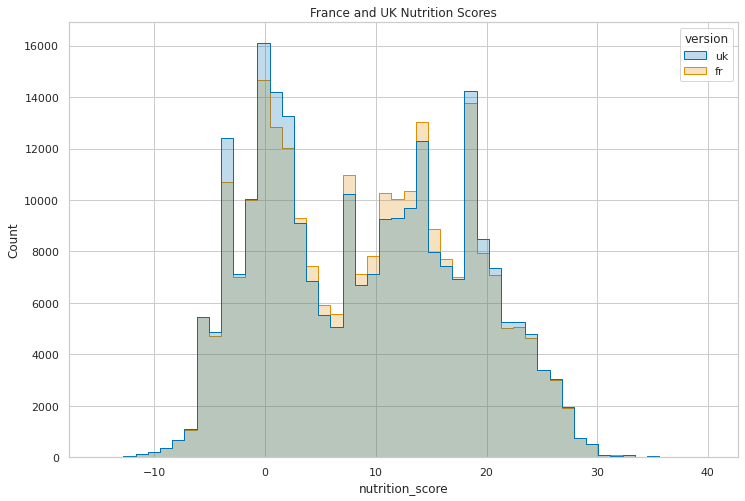

In [ ]:
# Visualize distribution of nutrition scores
uk_scores = ff_df[['nutrition_score_uk','nutrition_score']].dropna()['nutrition_score_uk'].to_frame().rename(columns={'nutrition_score_uk':'nutrition_score'})
uk_scores['version'] = 'uk'
fr_scores = ff_df[['nutrition_score','nutrition_score_uk']].dropna()['nutrition_score'].to_frame()
fr_scores['version'] = 'fr'
scores = pd.concat([uk_scores,fr_scores]).reset_index(drop=True)

sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(figsize=(12,8))
with sns.color_palette('colorblind'):
  sns.histplot(data=scores, x='nutrition_score', hue='version', element='step', bins=50, ax=ax).set(title='France and UK Nutrition Scores')
fig.show()

The figure above shows a bar plot of the nutrition scores of France and the UK. The x-axis is the score range, and the y-axis is the count of scores. The scores range from -15 to 40. The blue bars represent UK version of nutrition scores, and the orange bars show France version of nutrition scores. 

The figure brings us an intuitive view of the distribution of scores in France and the UK, which might enable us later to choose the better scoring system in our analysis. The figure shows that score distribution from the France and the UK systems are highly similar. However, we can see more products with a nutrition score of 2 and below in the UK system, which means the UK system ranks more products as "healthy" food and indicates the France system is stricter.



Now, we focus on the entries with different scores in France and UK nutrition scoring systems.

In [ ]:
# Compare nutrition scores in different system
compare_scores = ff_df[ff_df['nutrition_score']!=ff_df['nutrition_score_uk']][['product_name','brands','nutrition_score','nutrition_score_uk']].dropna()
compare_scores['diff'] = compare_scores['nutrition_score'] - compare_scores['nutrition_score_uk']
compare_scores['higher_uk'] = compare_scores['diff'].apply(lambda x: True if x<0 else False)
compare_scores['abs_diff'] = compare_scores['diff'].apply(lambda x: abs(x))
compare_scores.describe()

,nutrition_score,nutrition_score_uk,diff,abs_diff
count,12999.000000,12999.000000,12999.000000,12999.000000
mean,11.107624,7.499038,3.608585,7.499808
std,5.812308,9.448135,7.528315,3.667011
min,-10.000000,-9.000000,-14.000000,1.000000
25%,7.000000,0.000000,-5.000000,5.000000
50%,12.000000,2.000000,6.000000,7.000000
75%,15.000000,18.000000,10.000000,10.000000
max,40.000000,31.000000,21.000000,21.000000


It seems like the France version is stricter than the UK version in general. Let's visualize this.

In [ ]:
# Visualize comparsion of nutrition scores
fig = px.scatter(compare_scores, x='nutrition_score', y='nutrition_score_uk', size='abs_diff', color='higher_uk', hover_data=['product_name','brands'], 
                 width=800, height=600, template='plotly_white', labels={
                     'nutrition_score':'France Nutrition Score',
                     'nutrition_score_uk':'UK Nutrition Score',
                     'higher_uk':'UK version is higher'},
                 title='Products With Different Scores in France and UK Version of Nutrition Scores')
fig.show()

The figure above is a scatter plot showing each product's UK and France scores. Every point (circle) is a product: its x-coordinate is France's score, while its y-coordinate is the UK's. The size of the point represents the absolute value of the difference in France and the UK score. Red points are those products whose UK score is higher than France's, while blue points are the reverse. 

Here we can see the number of blue points is much more than the number of red points, which indicates that the France version of nutrition scores tend to be higher than the UK version.

Although the France and UK versions of nutrition scores are the same for most of the time, our analysis shows that the France version of nutrition scores tend to be higher than the UK version, implying that the France version is more conservative in classifying food as "healthy". Moreover, a study [1] comparing the nutrition scores across 12 countries shows that France nutrition score is slightly more likely to change the consumers' ability to correctly rank products between no label and labelling conditions. Therefore, __we decide to use France nutrition scores for the rest of our analysis.__

[1] Egnell M, Talati Z, Hercberg S, Pettigrew S, Julia C. Objective Understanding of Front-of-Package Nutrition Labels: An International Comparative Experimental Study across 12 Countries. Nutrients. 2018; 10(10):1542. https://doi.org/10.3390/nu10101542

## Distribution of Product Availability Across Country
Let's visualize the distribution of the products in this dataset across countries (recall the "countries" column represents the countires that the product is available to be purchased in).

Let's project two columns and explode the lists we made in the 'countries' column to make this easier.

In [ ]:
# Explode list of countries to rows
exploded_ff_df = ff_df[['countries', 'nutrition_score']].explode('countries')

Let's see what countries we are left with.

In [ ]:
# replace easy string inconsistencies

exploded_ff_df['countries'].unique()

array(['France', 'United States', 'United Kingdom', 'Canada',
       'Switzerland', 'Spain', 'Germany', 'Slovenia', 'Bangladesh',
       'Italy', 'Romania', 'Australia', 'Portugal', 'Belgium',
       'Netherlands', 'Guadeloupe', 'Dominican Republic', 'Ireland',
       'Réunion', 'Taiwan', 'Brazil', 'Mexico', 'Saudi Arabia',
       'United Arab Emirates', 'Iraq', 'Kuwait', 'Moldova',
       'New Caledonia', 'nan', 'Singapore', 'Finland', 'Sweden',
       'French Polynesia', 'New Zealand', 'Thailand', 'Panama',
       'Costa Rica', 'Scotland', 'Trinidad and Tobago', 'China',
       'Hong Kong', 'Luxembourg', 'Lebanon', 'Denmark', 'Belgie',
       'Nederland', 'Malaysia', 'Guyana', 'Serbia', 'Martinique',
       'Barbados', 'Aruba', 'Norway', 'Haiti', 'El Salvador', 'Bahrain',
       'Guatemala', 'Morocco', 'Oman', 'South Korea', 'Chile', 'Cuba',
       'Japan', 'Israel', 'Philippines', 'United-states-of-america',
       'Austria', 'Guinea', 'Jordan', 'Russia',
       'Saint Pierre and Mi

Here, we can see there are non-english (some are in French, denoted by 'fr:(country name)' and some use non-alphabetic characters) and non-standardized (Ex. 'United-states-of-america' instead of 'United States of America') entries. The vast majority of entries have capitalized, english names of countries with spaces between parts of the name as necessary. So, we just remove non-english entries and reformat non-space-separated (dash separated) entries. 

In [ ]:
# Country cleaning
exploded_ff_df['countries'] = exploded_ff_df['countries'].apply(lambda country: country.replace('-', ' '))
cleaned_exploded_ff_df = exploded_ff_df[~exploded_ff_df.countries.str.contains(r'[^\w\s]')] # remove names with characters that are non-letters or whitespace
cleaned_exploded_ff_df = cleaned_exploded_ff_df[cleaned_exploded_ff_df.countries.map(lambda x: x.isascii())] # remove names with non-english characters
# sorted(cleaned_exploded_ff_df['countries'].unique())

Let's check to see how many rows we removed.

In [ ]:
# Count the dropped rows
print("Lost " + str(exploded_ff_df.shape[0] - cleaned_exploded_ff_df.shape[0]) + " of " + str(exploded_ff_df.shape[0]) + " rows")

Lost 472 of 363872 rows


Additionally, let's remove 'Virgin Islands of the United States' (not compatible with our visualization), 'nan', 'Ap' (an abbrevation for Asia/Pacific Region), and 'World' (We didn't do this above so we could see how many rows were lost before this step). Also, there are no variations of country names except "United States" and "United states of america." We handle that here.


In [ ]:
# Country cleaning
cleaned_exploded_ff_df = cleaned_exploded_ff_df[(cleaned_exploded_ff_df['countries'] != 'nan') & (cleaned_exploded_ff_df['countries'] != 'World') & (cleaned_exploded_ff_df['countries'] != 'Ap') & (cleaned_exploded_ff_df['countries'] != 'Virgin Islands of the United States')]
cleaned_exploded_ff_df.loc[cleaned_exploded_ff_df["countries"] == "United states of america"] = 'United States'
None

In [ ]:
# Geographical visualization of number of products by country
count_by_country = cleaned_exploded_ff_df[['countries','nutrition_score']]
count_by_country = count_by_country.groupby('countries').count()
count_by_country.reset_index(inplace=True)

fig = px.choropleth(data_frame = count_by_country, locations="countries", locationmode = 'country names',
                    color="nutrition_score", hover_name='nutrition_score', color_continuous_scale=px.colors.sequential.OrRd,
                    labels = {'nutrition_score' : 'Number of Products Available', 'countries':'Country'}, 
                    title = 'Number of Products Available by Country')
fig.show()

The figure above shows the number of available products in each country on a geographical map. The color bar is shown on the right side. The more products available, the more color is profound. Light blue indicates data missing in specific countries or regions.

We can see that a huge majority of these products in this dataset are available in the United States and France. Although this is the case, we can still get an idea of how healthy a country's products are if they have a large enough amount of entries. Let's look at the average nutrition score of countries with at least 300 entries.

In [ ]:
# Geographical visualization of average scores by country
countries_ge_1000 = count_by_country[count_by_country['nutrition_score'] >= 300]['countries'].unique() # note we counted over product name above
countries_ge_1000_ff_df = exploded_ff_df[exploded_ff_df.countries.map(lambda x: x in countries_ge_1000)]
avg_score_by_country = countries_ge_1000_ff_df.groupby(by='countries').mean().sort_values(by='nutrition_score', ascending=False).reset_index()

# change color

fig = px.choropleth(data_frame = avg_score_by_country, locations="countries", locationmode = 'country names',
                    color="nutrition_score", hover_name='nutrition_score', color_continuous_scale=px.colors.sequential.OrRd,
                    labels = {'nutrition_score' : 'Nutrition Score', 'countries':'Country'}, 
                    title = 'Average Nutrition Scores by Country')
fig.show()

The figure above shows the average nutrition scores in each country on a geographical map. The color bar is shown on the right side. The higher the average nutrition scores are, The more color is profound. Light blue indicates data missing in specific countries or regions.

It seems there's not too much of a difference in the nutrition scores of different countries, so we do not think the countries a given product is available in will be very useful in predicting the product's nutritional value. Spain, however, did have a particularly low average nutritional score for its products denoting healthier products.

## Does being "organic" mean that a product is Healthier? How about "diet" or "lite?"
One common theory is that companies often use keywords like "organic" in a product's name to lead customers into believing a product is healthy. Here, we aim to see if this idea has some data-driven truth behind it.

Let's first see what the median nutrition score is over all products.

In [ ]:
# Calculate median nutrition score
median_nut_score = ff_df['nutrition_score'].median()
print("Overall median nutrition score: " + str(median_nut_score))

Overall median nutrition score: 10.0


Let's calculate the median, minimum, and maximum nutrition score for products with "organic," "diet, and "lite" products. Additionally, let's visualize these numbers. Note that the red line is the median nutrition score for the entire dataset.

In [ ]:
# Filter the products with different keywords
org_df = ff_df[(ff_df['product_name'] != None) & (ff_df.product_name.str.contains('organic'))][['product_name', 'nutrition_score']] # also taking the product name here in case reader would like to verify or for later analysis
diet_df = ff_df[(ff_df['product_name'] != None) & (ff_df.product_name.str.contains('diet'))][['product_name', 'nutrition_score']]
lite_df = ff_df[(ff_df['product_name'] != None) & ((ff_df.product_name.str.contains('lite')) | (ff_df.product_name.str.contains('light')))][['product_name', 'nutrition_score']]

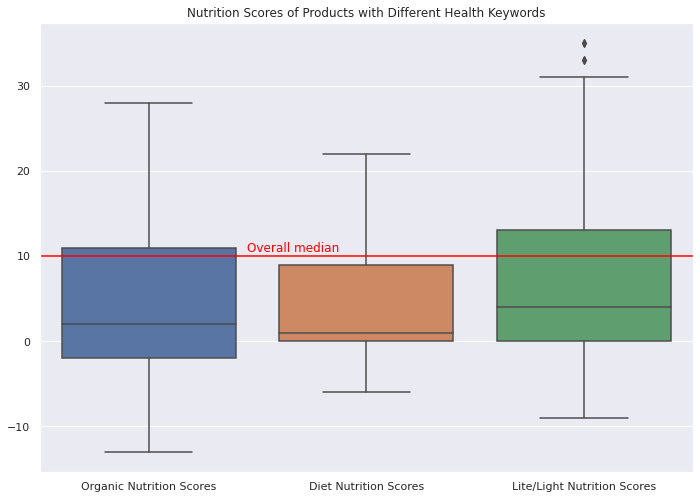

In [ ]:
# Visualize Nutrition Scores of Products with Different Health Keywords
healthy_keyword_nut_scores = pd.concat([org_df.rename(columns={'nutrition_score':'Organic Nutrition Scores'})['Organic Nutrition Scores'],
                                        diet_df.rename(columns={'nutrition_score':'Diet Nutrition Scores'})['Diet Nutrition Scores'],
                                        lite_df.rename(columns={'nutrition_score':'Lite/Light Nutrition Scores'})['Lite/Light Nutrition Scores']],
                                        axis=1)
sns.set(rc={'figure.figsize':(11.7,8.27)})
keyword_boxplot = sns.boxplot(data=healthy_keyword_nut_scores)
keyword_boxplot.axhline(median_nut_score, color="red")
keyword_boxplot.text(.45,median_nut_score+.5,'Overall median', color='red')
keyword_boxplot.set(title="Nutrition Scores of Products with Different Health Keywords")
None

The box plot showing the nutrition scores of products with three different keywords. The blue one is the nutrition scores of products with "organic" in their names. The orange one is the nutrition scores of products with "diet" in their terms. The green one is the nutrition scores of products with "lite" or "light" in their names. We also show an overall median nutrition score with a red horizontal line for reference. 

Interestingly, the upper extremes reach quite high in the box plots. "Lite" even has some points with nutrition scores in the 30s. Let's get some concrete numbers from this box and whisker plot.

In [ ]:
# Show Statistics of Nutrition Scores of Products with Different Health Keywords
print("Organic Min Nutrition Score: " + str(org_df['nutrition_score'].min()))
print("Organic Median Nutrition Score: " + str(org_df['nutrition_score'].median()))
print("Organic Max Nutrition Score: " + str(org_df['nutrition_score'].max()))
print()
print("Diet Min Nutrition Score: " + str(diet_df['nutrition_score'].min()))
print("Diet Median Nutrition Score: " + str(diet_df['nutrition_score'].median()))
print("Diet Max Nutrition Score: " + str(diet_df['nutrition_score'].max()))
print()
print("Lite Min Nutrition Score: " + str(lite_df['nutrition_score'].min()))
print("Lite Median Nutrition Score: " + str(lite_df['nutrition_score'].median()))
print("Lite Max Nutrition Score: " + str(lite_df['nutrition_score'].max()))

Organic Min Nutrition Score: -13.0
Organic Median Nutrition Score: 2.0
Organic Max Nutrition Score: 28.0

Diet Min Nutrition Score: -6.0
Diet Median Nutrition Score: 1.0
Diet Max Nutrition Score: 22.0

Lite Min Nutrition Score: -9.0
Lite Median Nutrition Score: 4.0
Lite Max Nutrition Score: 35.0


From the visualization and calculations above, we can see that "diet," "organic," and "lite/light" does often indicate a healthier product according to this dataset. Thus, this keyword information can be useful in determing the nutritional value of product, which means this attribute could be encoded to serve as a feature in modelling. However, consumers should still be careful because there are still some products that have healthy sounding keywords but are not healthy.

## Exploring Nutritional Scores by Brand Characteristics
Here we discover how nutritional scores relate to different facets of the companies that made them. We use the terms "company" and "brand" interchangeably here.

### Nutrition Scores by Brand
**First, some more cleaning:** Some rows that have multiple brands just have the extended version of the first company. For example, 'Kettle' and 'Kettle Foods', or 'Asda', 'Asda Extra Special'. (Note, we considered using Jaccard similarity here, but some of the names of the same brands have many extra words like 'Asda' and 'Asda Extra Special', and Jaccard is more looking for a match, such as between 'Asda' and 'A%27ssda'. Also note that we did not do this in the cleaning section so that we may use all variations of brand names when scraping wikipedia later to have the best chance of getting a hit.)

<!-- In this scenario, there's almost always just the single brand and its extended name in the list(eg. only 'Kettle' and 'Kettle Foods' and no other brands). So we handle that case accordingly. -->

In [ ]:
# This function takes out different versions of brand names if they contain the same word or name.
def take_out_duplicate_brands(brand_list):
  if len(brand_list) <= 1:
    return brand_list

  word_separated_lists = [brand.split(" ") for brand in brand_list] # list of each brand's words separated into a list
    
  new_brand_list = []
  for i, word_separated_list_1 in enumerate(word_separated_lists):
    found_similar = False
    for j, word_separated_list_2 in enumerate(word_separated_lists):
      if i < j: # to ensure no duplicate or self comparisons
        for word_1 in word_separated_list_1:
          for word_2 in word_separated_list_2:
            if word_1.lower() == word_2.lower():
              found_similar = True
    if (not found_similar) and brand_list[i] != 'nan':
        new_brand_list.append(brand_list[i])
  return new_brand_list

# take out different variants of company names and drop duplicates
brands_exploded = ff_df[['brands', 'nutrition_score']]
brands_exploded['deduplicated_brands'] = brands_exploded['brands'].apply(lambda brands_list: take_out_duplicate_brands(brands_list)) # create new col so we don't mess with original brands col
brands_exploded = brands_exploded.explode('deduplicated_brands').dropna().reset_index().drop(columns=['brands', 'index']).rename(columns={'deduplicated_brands':'brands'})

<ipython-input-33-6e3a993b7dcb>:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Now, let's visualize the distribution of average nutrition scores of companies with at least 5 products.

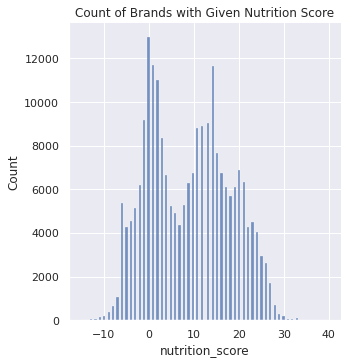

In [ ]:
# get counts for each brand and remove brands with < 5 products
count_brands = brands_exploded.groupby(by='brands', as_index=False).count()
count_brands = count_brands[count_brands['nutrition_score'] >= 5]

# merge with count_brands to just get < 5 products with nutrition scores
brands_5_products = brands_exploded.merge(count_brands['brands'], left_on="brands", right_on="brands")

sns.displot(brands_5_products, x="nutrition_score").set(title='Count of Brands with Given Nutrition Score')
None

The bar plot shows count of brands with given nutrition score. 

Interestingly, we can see that the avereage nutrition scores of brands seem to form a binomial distribution.

Let's quickly see what the top ten healthiest and unhealthiest brands are in this dataset.

In [ ]:
# get 10 most and least nutrition brands
top_10 = brands_5_products.groupby(by="brands").mean().sort_values(by='nutrition_score', ascending=False).head(10).reset_index() # note top means less healthy
bottom_10 = brands_5_products.groupby(by="brands").mean().sort_values(by='nutrition_score').head(10).reset_index()

print("Top Ten Healthiest Brands in Open Food Facts Dataset")
print(top_10)
print()
print("Top Ten Unhealthiest Brands in Open Food Facts Dataset")
print(bottom_10)

Top Ten Healthiest Brands in Open Food Facts Dataset
                                 brands  nutrition_score
0                          Cafe Escapes        32.600000
1  Green Mountain Coffee Roasters  Inc.        31.666667
2                 Cary's Of Oregon  Llc        30.800000
3                              GOLDKENN        29.000000
4                    Chef Shamy Gourmet        28.500000
5    Massimo Zanetti Beverage Usa  Inc.        28.250000
6       Health Mania Natural Foods  Llc        28.000000
7                          Grove Square        27.833333
8                              Goldkenn        27.500000
9          Gelateria Patisceria Vigneri        27.000000

Top Ten Unhealthiest Brands in Open Food Facts Dataset
                           brands  nutrition_score
0                 Verdifresh S.L.        -7.750000
1  GAC - Grupo Alimentario Citrus        -7.750000
2                        Barnetti        -7.600000
3                        OAKLANDS        -7.400000
4        

Clearly some brands produce mainly healthy or mainly unhealthy products. Thus, the brand could be highly correlated with the nutrition score and, thus, could be  useful as a feature in predicting nutrition score for a new product.

### Do private, subsidiary (owned by another company), or public companies make healthier products? How about older or new companies?
There are convential conceptions about the type of company and whether or not they make nutritious products. Many believe that public companies have issues keeping quality control when it comes to nutrition, using excess preservatives, sugars, fats, and other nutrients to deal with mass scaling. Subsidiary companies are often throught to have concerns with quality control as well because the decisions are not made in the best interest of the company or their product, but rather the best interest of the parent company. Another common belief is that older companies tend to make less healthy foods because they were founded in a time before modern revolutionary health studies. Let's see if these ideas hold merit. We draw from wikipedia here to get the type of company (public, subsidiary, or private), and the founding date.

Originally, we scraped from all unique URLs that we could create from our dataset. However, this took around 5 hours. As we know readers are not going to run that, we saved the resulting dataframe with only brands we were able to retrieve the founding year or company type. Below, we go through a couple hundred URLs to demonstrate the code, but afterwards we just use the saved dataframe.

In [ ]:
# Get a list of wikipedia URLs (that may or may not exist) from out dataframe
crawl_list = set()

for brand_list in ff_df['brands']:
  for brand in brand_list:
    if brand != None:
      no_space_brand = str(brand).replace(' ', '_') # I would use .lower() here but wikipedia URLs are case sensitive
      if no_space_brand != None:
        crawl_list.add('https://en.wikipedia.org/wiki/' + no_space_brand)

print(str(len(crawl_list)) + " potential wikipedia URLs")

61098 potential wikipedia URLs


Make requests.

In [ ]:
# # Use urllib.urlopen to crawl all pages in crawl_list, and store the response of the page
# # in list pages 
%%time

pages = []
# urls_that_worked = []

for i, url in enumerate(crawl_list):
    if i >= 300: #comment this if statement out to run the entire crawl list (5 hours)
      break
    if i % 100 == 0:
      print(str(i) + "/" + str(len(crawl_list)))
    # if i % 10000 == 0:
    #   np.save('./drive/MyDrive/' + str(i) + '_urls_that_worked', urls_that_worked)
    page = url.split("/")[-1] #extract the brand name at the end of the url
    if page == None:
      continue

    url_list = list(urllib.parse.urlsplit(url))
    url_list[2] = urllib.parse.quote(url_list[2])
    url_ascii = urllib.parse.urlunsplit(url_list)
    try:
      response = urllib.request.urlopen((url_ascii))
      #Save page and url for later use.
      pages.append(response)
      # urls_that_worked.append(url)

    except urllib.error.URLError as e: # Usually because page was not found
      continue
      # print(e.reason)

0/61098
100/61098
200/61098
CPU times: user 1.74 s, sys: 335 ms, total: 2.08 s
Wall time: 1min 36s


Retrieve data from wikipedia page using XPath. Also, clean the founding year and company type columns while iterating through.

In [ ]:
# Some founding years data we find from wikipedia do not just have the year, so we need to get the year from this string
def find_year_from_str(founded_string):
  for i, character in enumerate(founded_string):
    if i < len(founded_string) - 3: # can't check a four digit year if there's less than 4 digits to check
      if character == "1" or character == "2": # quick check to take out four digit numbers that are not from this century or the last (assuming there's no companies founded before year 1000)
        if founded_string[i:i+4].isnumeric():
          return int(founded_string[i:i+4])
  return None

# Some company type data we find from wikipedia does not just have the company type, so we need to get the year from this string
def get_company_type_from_str(company_type_string):
  company_type_string = company_type_string.lower()
  for i, character in enumerate(company_type_string):
    if i < len(company_type_string) - 9 and company_type_string[i:i+10] == 'subsidiary':
      return "subsidiary"
    if i < len(company_type_string) - 6 and company_type_string[i:i+7] == 'private':
      return "private"
    if i < len(company_type_string) - 5 and company_type_string[i:i+6] == 'public':
      return "public"
  return None

# Sometimes the list of elements we receive contains more than just the founded year (for example, sometimes it contains a link element).
# Thus we need to cycle through and find the element that is actually text (which is why we have an if str(element) statement)
def get_founded_year_from_list_of_elements(element_list):
  for element in element_list:
    if str(element):
      founded_year = find_year_from_str(element)
      if founded_year:
        return  founded_year
  return None

# Sometimes the list of elements we receive contains more than just the company type (for example, sometimes it contains a link element <a>).
# Thus we need to cycle through and find the element that is actually text (which is why we have an if str(element) statement)
def get_company_type_from_list_of_elements(element_list):
  for element in element_list:
    if str(element):
      company_type = get_company_type_from_str(element)
      if company_type:
        return  company_type
  return None

brand_df = pd.DataFrame(columns=['brands','company_type','founded'])
count=0
for page in pages: # For all the pages we received responses for
  count += 1
  if(count % 100 == 0):
    print(str(count) + " / " + str(len(pages)))
  try:
    tree = etree.HTML(page.read().decode("utf-8"))  #create a DOM tree of the page
  except: # Could not create DOM tree
    continue
  if(tree == None): # Got no DOM tree
    continue
  url = page.geturl()
  to_add = {"brands":url[url.rfind('/')+1:]} # get's the brand name from the last part of the URL

  if tree.xpath('//table[contains(@class,"vcard")]'): # find the wikipedia vcard element, if exists
    vcard = tree.xpath('//table[contains(@class,"vcard")]')[0]
  else: # sometimes doesn't exist, especially if the page we found wasn't a company
    continue

  for tr in vcard.xpath('//tr'): # iterate through each //tr element
    if tr.xpath('./th/text()') and tr.xpath('./th/text()')[0] == 'Type': # th element was the company type
      if(tr.xpath('./td/text()')):
        to_add['company_type'] = get_company_type_from_list_of_elements(tr.xpath('./td/text()')) # see definition of function above
    elif tr.xpath('./th/text()') and tr.xpath('./th/text()')[0] == 'Founded': # th element was the founding year
      if(tr.xpath('./td/text()')):
        to_add['founded'] = get_founded_year_from_list_of_elements(tr.xpath('./td/text()')) # see definition of function above
  
  if len(to_add) > 1: # if it's more than just the brand, then a company type or founded entry has been found
      brand_df = brand_df.append(to_add, ignore_index=True)

  brand_df['brands'] = brand_df['brands'].apply(lambda brand: str(brand).replace('_', ' ')) # switch back to spaces

In [ ]:
# Check again for updated dataframe
brand_df.head(10)

,brands,company_type,founded
0,Heinz,NaN,1869
1,Glico,NaN,1922
2,General Mills Inc.,NaN,1856
3,Kentz,NaN,1919
4,Dean%27s,NaN,1925
5,ASDA,NaN,1949
6,Haagen Dazs,NaN,1960
7,Hannaford Bros. Co.,NaN,1883
8,Foodista,NaN,2008
9,Cardhu,NaN,1824


Here we import the precomputed brand_df.


In [ ]:
# Load the precomputed brand data
brand_df = pd.read_csv('./drive/MyDrive/entire_brand_df.csv')
brand_df.head(10)
print("Number of entries in imported brand_df: " + str(len(brand_df)))

Number of entries in imported brand_df: 1249


**A bit more cleaning:** Let's just use the founded column decade rather than year to make it easier to visualize (e.g. 1984 to 1980s). Moreover, most brands were founded after the Industrial Revolution. Therefore, we label founding years before 1840s as " before 1840s". Additionally, we need to use Jaccard similarity to merge with the original 'brands_exploded' dataframe because some characters were encoded in the URL (e.g. 'Lovin' Scoopful' was 'Lovin%27 Scoopful' in the URL) 

In [ ]:
def convert_to_decade_string(founded):
  if founded != None:
    try: # Getting weird NaN error
      return str(int(float(founded) / 10) * 10) + 's'
    except:
      return None
  return None

# create extended food facts dataframe with founded data and company type
tok = sm.QgramTokenizer(qval=5,return_set=True) # 5 seems reasonable with these brand name lengths

ext_ff_df = ssj.jaccard_join(brands_exploded.reset_index(), brand_df.reset_index(), l_key_attr='index', r_key_attr='index', l_join_attr='brands',
                             r_join_attr='brands', tokenizer=tok, threshold=0.35, l_out_attrs=['brands', 'nutrition_score'], r_out_attrs=['company_type', 'founded'])
ext_ff_df = ext_ff_df.drop(columns = ['_id',	'l_index',	'r_index', '_sim_score']).rename(columns={'l_brands':'brands',	'l_nutrition_score':'nutrition_score',
                                                                                   'r_company_type':'company_type',	'r_founded':'founded'})
# do a bit of modification to make the data easier to visualize
ext_ff_df['founded'] = ext_ff_df['founded'].apply(lambda founded: convert_to_decade_string(founded) if founded>=1840 else ' before 1840s')
ext_ff_df = ext_ff_df.drop_duplicates()
print("Number of products for which we found brands for: " + str(len(ext_ff_df)))

/usr/local/lib/python3.8/dist-packages/py_stringsimjoin/utils/generic_helper.py:76: FutureWarning:

In a future version of pandas all arguments of DataFrame.dropna will be keyword-only

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Number of products for which we found brands for: 11437


Let's check out the unique values we retrieved.

In [ ]:
# Check the decades and company types
print(ext_ff_df['founded'].unique())
print(ext_ff_df['company_type'].unique())

['2000s' '1960s' '1930s' '1990s' '1920s' '2010s' '1980s' '1910s' '1860s'
 '1950s' '1940s' '1870s' '1890s' '1900s' '1970s' ' before 1840s' '1850s'
 '1880s' '1840s']
[nan 'private' 'subsidiary' 'public']


Let's see how many products we have of each company type and founding decade.

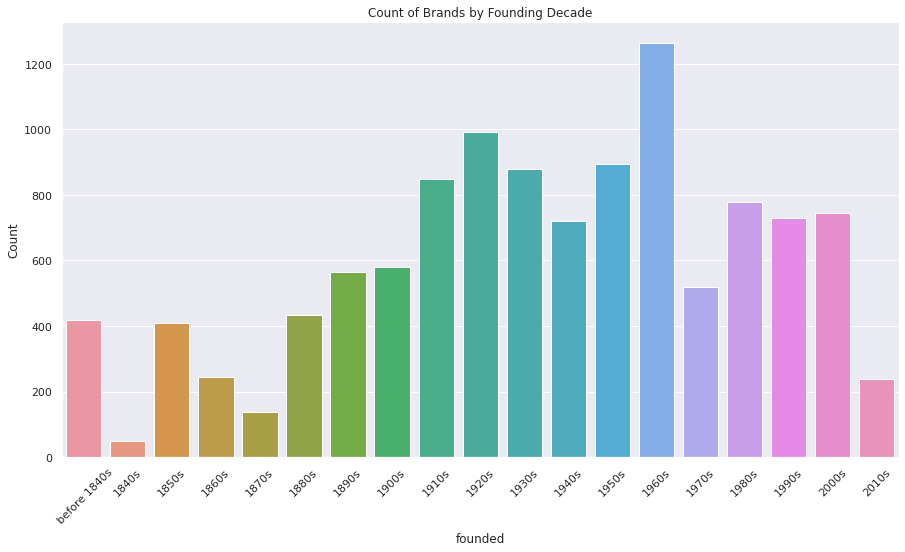

In [ ]:
# Visualize Count of Brands by Founding Decade
founded_df = ext_ff_df[['founded', 'nutrition_score']].dropna(subset=['founded']).groupby('founded').count().reset_index()

plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'founded', y = 'nutrition_score', data = founded_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set(title='Count of Brands by Founding Decade', ylabel='Count')
None

The bar plot shows count of brands by founding decade. 

We can see an upward trend from 1840s to 1960s in founding new brands while a decrease from 1960s to 2010s.

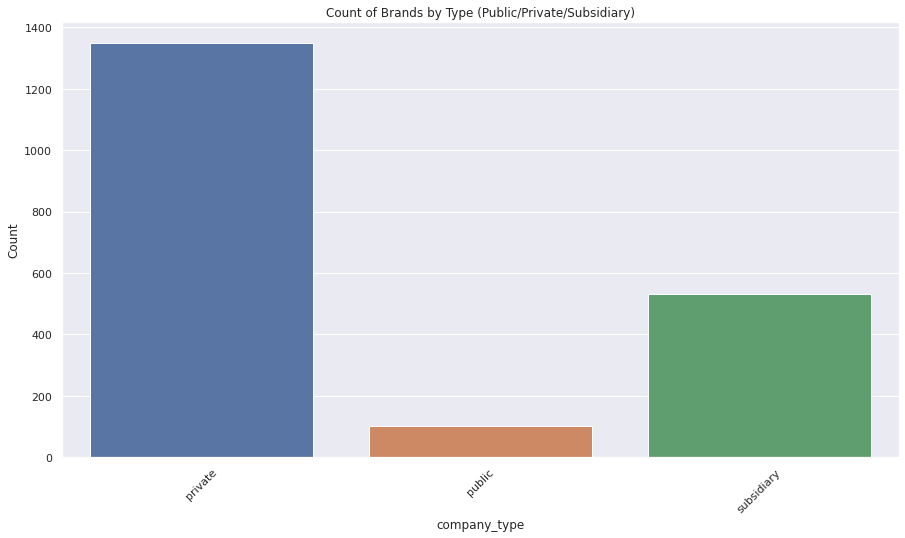

In [ ]:
# Visualize Count of Brands by Type
type_df = ext_ff_df[['company_type', 'nutrition_score']].dropna(subset=['company_type']).groupby('company_type').count().reset_index()

plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'company_type', y = 'nutrition_score', data = type_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set(title='Count of Brands by Type (Public/Private/Subsidiary)')
ax.set(ylabel='Count')
None

The bar plot shows count of differnet type of brands. The blue one is the private company. The orange one is the public company. The green one is the subsidiary company. 

We can see that the number of private companies is far much more than two other types.

How about the count of products of each company type from each decade?

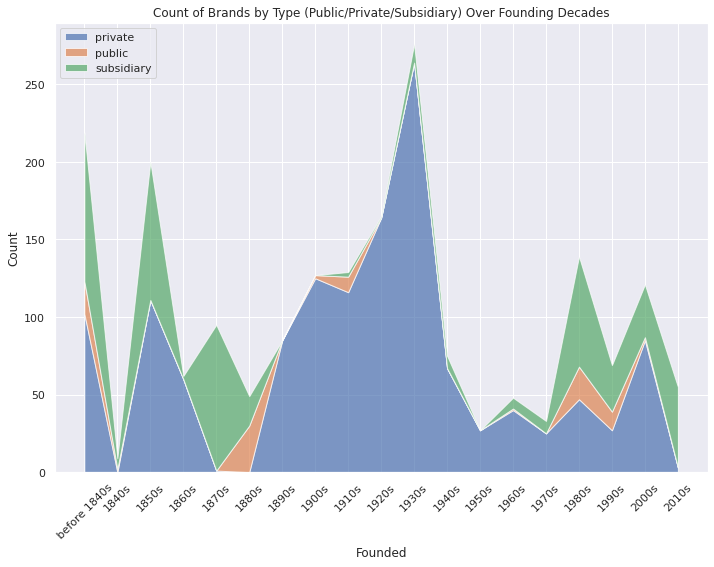

In [ ]:
# Visualize Count of Brands by Type Over Founding Decades
combo_df = ext_ff_df[['company_type', 'founded', 'nutrition_score']].dropna(subset=['founded', 'company_type']).groupby(['founded', 'company_type']).count().reset_index().pivot(
    index = 'founded', columns = 'company_type', values='nutrition_score').fillna(0).reset_index()

x = combo_df['founded'].to_list()
y1 = combo_df['private'].to_list()
y2 = combo_df['public'].to_list()
y3 = combo_df['subsidiary'].to_list()
sns.set_theme()
plt.stackplot(x, y1,y2,y3, labels=['private','public','subsidiary'], alpha=.7)
plt.xticks(rotation=45)
plt.xlabel('Founded')
plt.ylabel('Count')
plt.title('Count of Brands by Type (Public/Private/Subsidiary) Over Founding Decades')
plt.legend(loc='upper left')
plt.show()

The plot shows count of different type of brands by their founding decade. The blue one is the private company. The orange one is the public company. The green one is the subsidiary company. 

We can see that before 1890s and after 1940s, there are more subsidiary companies founded than private company, while between 1890s and 1940s private companies grows the fastest. Founding of all three different companies share similar trends across time.

Let's analyze nutrition scores with respect to public/private and founding year.

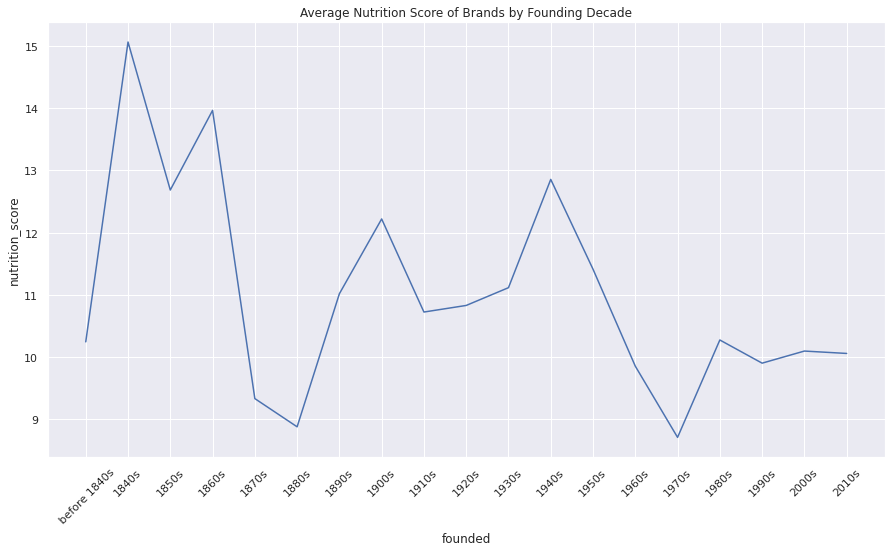

In [ ]:
# Visualize Average Nutrition Score of Brands by Founding Decade
founded_df = ext_ff_df[['founded', 'nutrition_score']].dropna().groupby('founded').mean().reset_index()

plt.figure(figsize = (15,8))
ax = sns.lineplot(x = 'founded', y = 'nutrition_score', data = founded_df)
x_ticks = founded_df['founded'].dropna().unique()
x_ticks.sort()
ax.set_xticklabels(list(x_ticks), rotation = 45)
ax.set(title='Average Nutrition Score of Brands by Founding Decade')
None

The plot above shows nutrition scores of products founded in different time. 

We can see that, in general, the nutrition scores are getting lower and lower, indicating that new products are much more healthier than their previous counterparts.

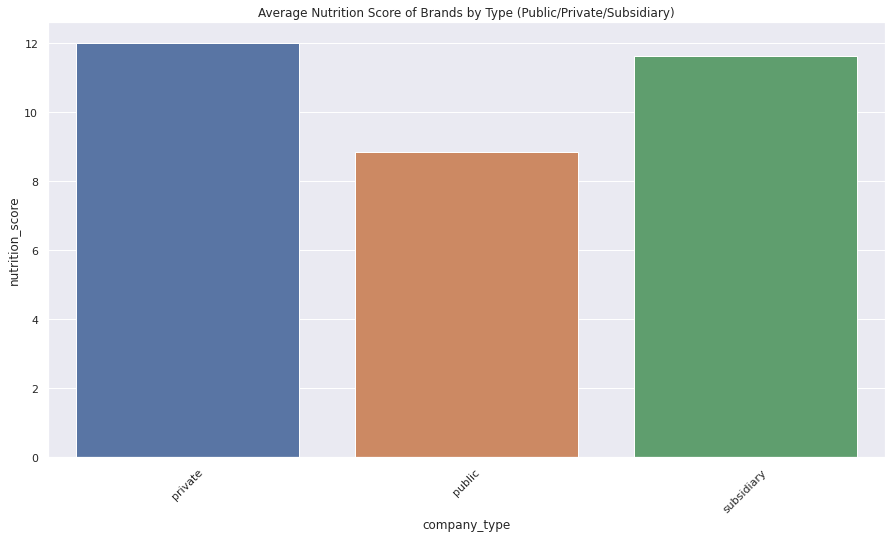

In [ ]:
# Visualize Average Nutrition Score of Brands by Type
type_df = ext_ff_df[['company_type', 'nutrition_score']].dropna().groupby('company_type').mean().reset_index()

plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'company_type', y = 'nutrition_score', data = type_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set(title='Average Nutrition Score of Brands by Type (Public/Private/Subsidiary)')
None

The plot shows nutrition scores of products produced by different kinds of companies. The blue one is the private company. The orange one is the public company. The green one is the subsidiary company. 

In general, nutrition scores are similar across different kinds of companies. However, scores of the public company is the lowest, indicating that they provide the healthiest food.

Now the average nutrition score of products made by each company type over each decade.

In [ ]:
# Visualize Average Nutrition Score of Brands by Type Over Founding Decades


combo_df = ext_ff_df[['company_type', 'founded', 'nutrition_score']].dropna(subset=['founded', 'company_type']).groupby(['founded', 'company_type']).mean().reset_index()

highlight = alt.selection(type='single', on='mouseover', fields=['company_type'], nearest=True)
base = alt.Chart(combo_df).encode(
    x='founded:N', y='nutrition_score:Q', color=alt.Color('company_type:N', scale=alt.Scale(scheme='category10'))
)
points = base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    title='Average Nutrition Score of Brands by Type (Public/Private/Subsidiary) Over Founding Decades',
    width=600, height=400
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(.8), alt.value(3))
)

points+lines

alt.LayerChart(...)

The plot shows the nutrition scores of different types of brands by their founding decade. The blue one is the private company. The orange one is the public company. The green one is the subsidiary company. 

However, it is hard for us to observe clear patterns and apply in our modeling. We do not move forward and dig deeper into these aspects. 

## Exploring Nutrients

Except for nutrition scores, our dataset provides information about nutrients, including energy, fat, saturated fat, carbohydrates, sugars, proteins, salt, and sodium. Some nutrients are subtypes of main nutrients. In our dataset, we define main nutrients as fat, carbohydrates, proteins, and salt. Note that energy is reported in "kJ per 100g", and other nutrients are reported in "g per 100g".

In [ ]:
# Check Nutrients
nutrition_df = ff_df[['nutrition_score','energy', 'fat', 'saturated_fat', 'carbohydrates', 'sugars', 'proteins', 'salt', 'sodium']].dropna()
nutrition_df['main_nutrients'] = nutrition_df['fat'] + nutrition_df['carbohydrates'] + nutrition_df['proteins'] + nutrition_df['salt']
nutrition_df.describe()

,nutrition_score,energy,fat,saturated_fat,carbohydrates,sugars,proteins,salt,sodium,main_nutrients
count,238533.000000,238533.000000,238533.000000,238533.000000,238533.000000,238533.000000,238533.000000,238533.000000,238533.000000,238533.000000
mean,9.176877,1172.075351,13.367942,4.913337,32.433032,14.794184,7.771801,1.613533,0.635250,55.186309
std,9.000967,768.383136,16.322374,7.441607,28.257215,19.693996,8.177840,132.369008,52.113783,136.336025
min,-15.000000,0.000000,0.000000,0.000000,0.000000,-17.860000,-3.570000,0.000000,0.000000,0.000000
25%,1.000000,448.000000,0.880000,0.000000,6.670000,1.200000,1.790000,0.100000,0.039370,23.550820
50%,10.000000,1176.000000,7.140000,1.790000,22.470000,5.000000,5.650000,0.635000,0.250000,54.087220
75%,16.000000,1711.000000,21.430000,7.100000,58.000000,22.580000,10.710000,1.353820,0.533000,88.101600
max,40.000000,22000.000000,200.000000,100.000000,165.000000,145.000000,305.000000,64312.800000,25320.000000,64384.950000


We need to do some additional data cleaning based on the following data validation methods:

* Any entries with more than 100g of total main nutrients are invalid data.
* The amount of nutrients should not be less than 0.
* The amount of any subtypes of the main nutrients is less than the amount of the main nutrient. For example, an entry is invalid when the amount of saturated fat is more than the amount of fat.

In [ ]:
# Data cleaning: Drop invalid rows
invalid = nutrition_df[(nutrition_df['main_nutrients']>100) | (nutrition_df['saturated_fat']>nutrition_df['fat']) |
                       (nutrition_df['sugars']>nutrition_df['carbohydrates']) | (nutrition_df['sodium']>nutrition_df['salt'] ) |
                       (nutrition_df['sugars']<0) | (nutrition_df['proteins']<0)]
print(f'There are a total of {len(invalid)} rows ({round(100*len(invalid)/len(nutrition_df),2)}%) invalid nutrition data')
nutrition_df = nutrition_df.drop(invalid.index, axis=0)
print('Invalid data dropped')

There are a total of 5076 rows (2.13%) invalid nutrition data
Invalid data dropped


Let's visualize the distribution of nutrition facts in boxplots.

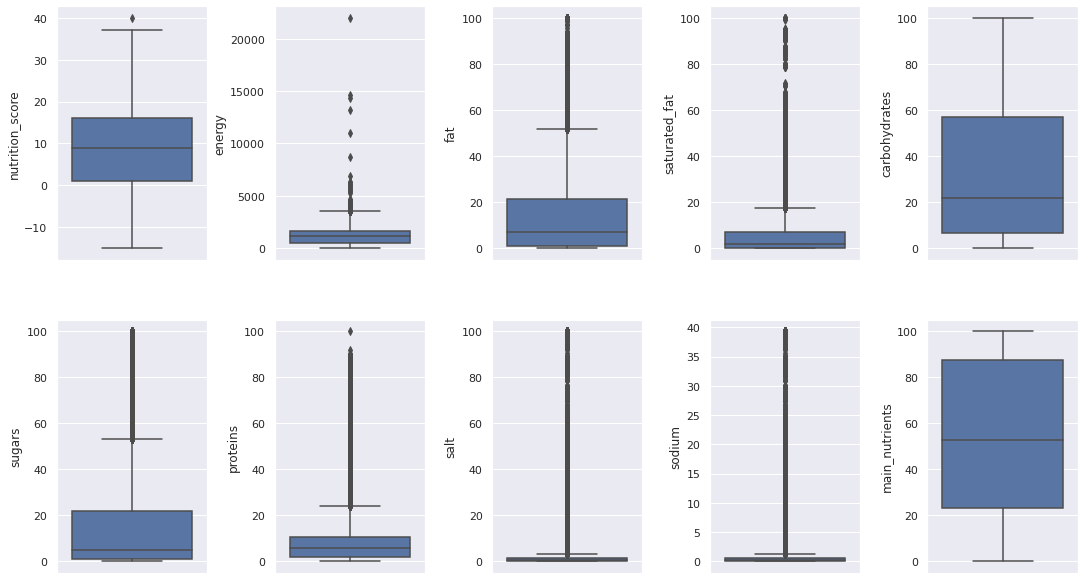

In [ ]:
# Visualize the distribution of nutrition facts
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(15,8))
index = 0
axs = axs.flatten()
for k,v in nutrition_df.items():
  sns.boxplot(y=k, data=nutrition_df, ax=axs[index])
  index += 1
plt.tight_layout(pad=.4, w_pad=.5, h_pad=5)

Here, we have ten box plots showing the distribution of nutrion scores and the amounts of different nutrients. 

There are outliers in most of the nutrient columns. We might need to handle these outliers in linear models. Let's calculate what percentage of data are outliers (1.5 standard deviations above and below the IQR).

In [ ]:
# Outlier Calaulations
for k, v in nutrition_df.items():
  q1 = v.quantile(0.25)
  q3 = v.quantile(0.75)
  irq = q3 - q1
  v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
  perc = np.shape(v_col)[0] * 100.0 / np.shape(nutrition_df)[0]
  print('%s outliers = %.2f%%' % (k, perc))

nutrition_score outliers = 0.00%
energy outliers = 0.36%
fat outliers = 2.75%
saturated_fat outliers = 7.18%
carbohydrates outliers = 0.00%
sugars outliers = 6.31%
proteins outliers = 4.94%
salt outliers = 5.17%
sodium outliers = 5.17%
main_nutrients outliers = 0.00%


Let's visualize correlation between each ingredient.

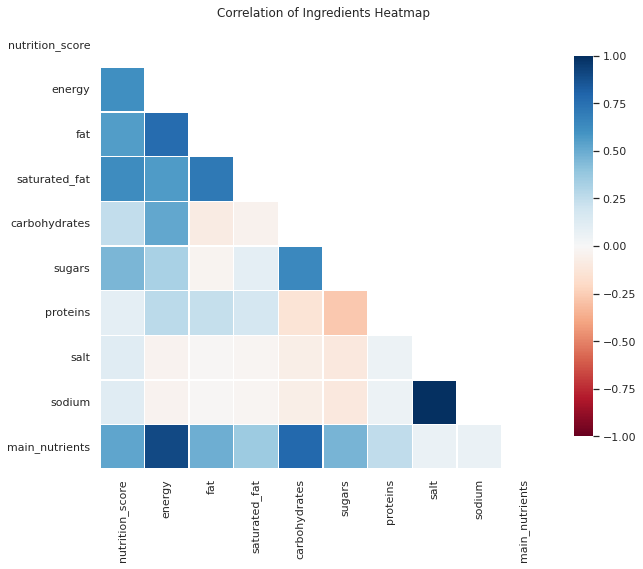

In [ ]:
# visualize correlation between each ingredient
cm = nutrition_df.corr()

sns.set_theme(style='white', palette=None)

mask = np.triu(np.ones_like(cm, dtype=bool))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, mask=mask, cmap=plt.cm.RdBu, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={'shrink':.7}).set_title(
                'Correlation of Ingredients Heatmap'
            )
plt.show()

Here, we show a heatmap of the correlation among different nutrients and nutrition scores. Positive correlations are colored blue and negative correlations are colored red. 

By definition, low-quality nutrients such as energy density, sugars, and salts rack up positive nutrition score, while high-quality nutrients include protein and others earn negative points (https://get.apicbase.com/nutri-score-science-based-nutritional-value-labelling-system/). However, we can learn from the figure that the correlation matrix shows a relatively low correlation between proteins and nutrition scores. Moreover, there seems to be some negative correlation between proteins and sugars. In addition, there are several highly correlated nutrients. We might need to remove multicollinearity in regression models.

# Models

## Linear Regression for Predicting Nutrition Score

In this section, we perform a Linear Regression on the data with the aim of predicting the nutrition score of a food given its attributes, such as nutrients and keywords. We believe this to be possible as one would expect that foods with certain ingredients, nutrients, etc. to be given a better (more negative) nutrition score.

As was mentioned before, encoding the presence of the keywords "organic", "diet", and "lite" may prove useful in modeling data as features given the results which we saw earlier. Thus, we one-hot-encode these keywords as columns in the dataset to include as features for our model. It was also mentioned that the brand could have an impact on nutrition score. However, here we reason that brand names oftentimes have a mix of healthy and unhealthy products, with their classification based more on their nutritional characteristics rather than the seller. Thus, we omit this as a feature in our modeling. In addition, we choose to normalize the data after splitting and before performing linear regression to improve the results. After selecting the attributes as features and the nutrition_score column as the label, we split the data into a training and testing sets with a size of 80% and 20%, respectively.

In [ ]:
# one-hot encoding of key words
nutrition_df['organic'] = ff_df[(ff_df['product_name'] != None) & (ff_df.product_name.str.contains('organic'))]['product_name'].apply(lambda x: 1)
nutrition_df['organic'] = nutrition_df['organic'].fillna(0).astype(int)
nutrition_df['diet'] = ff_df[(ff_df['product_name'] != None) & (ff_df.product_name.str.contains('diet'))]['product_name'].apply(lambda x: 1)
nutrition_df['diet'] = nutrition_df['diet'].fillna(0).astype(int)
nutrition_df['lite'] = ff_df[(ff_df['product_name'] != None) & (ff_df.product_name.str.contains('lite'))]['product_name'].apply(lambda x: 1)
nutrition_df['lite'] = nutrition_df['lite'].fillna(0).astype(int)

keep = ['energy', 'fat', 'saturated_fat', 'carbohydrates', 'sugars', 'proteins', 'salt', 'sodium', 'organic', 'diet', 'lite']

features = nutrition_df[keep]
score = nutrition_df['nutrition_score']

In [ ]:
# split for train and test data
x_train_lr, x_test_lr, y_train_lr, y_test_lr = train_test_split(features, score, test_size = 0.2)

# normalization of x train and test (performed after to avoid data leakage in split, normalized for regularized models)
scaler = StandardScaler()

x_train_lr_norm = pd.DataFrame(
    scaler.fit_transform(x_train_lr),
    columns = x_train_lr.columns
)

x_test_lr_norm = pd.DataFrame(
    scaler.transform(x_test_lr),
    columns = x_test_lr.columns
)

Using the splits formed above, we fit a Linear Regression model to the training data and predict the nutrition score of each product in the test data. 

We use the Root Mean Squared Error (RMSE) and the correlation coefficient $R^2$ to to assess the performance of the model.

The correlation coefficient measures the proportion of the variation in the dependent variable that is predictable from the independent variables. It ranges from 0 to 1 (inclusive), with a value closer to 1 indicating a better correlation.

The RMSE, on the other hand, is a more absolute measure of the model's accuracy, as it measures the differences between values predicted by the model and the actual values observed.

In [ ]:
# OLS
lin_reg = LinearRegression().fit(x_train_lr, y_train_lr)

y_pred_lr = lin_reg.predict(x_test_lr)

corr_coeff_lr = r2_score(y_test_lr.values, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test_lr.values, y_pred_lr))

print(f'The correlation coefficient R squared is {round(corr_coeff_lr, 4)}.')
print(f'The RMSE score is {round(rmse_lr, 4)}, which is about {100*round(rmse_lr/np.mean(score),2)}% of \
the mean nutrition score.')

The correlation coefficient R squared is 0.6473.
The RMSE score is 5.3194, which is about 59.0% of the mean nutrition score.


From this, we can that the model does not do well in predicting the nutrition score. While the correlation coefficient indicates that about 64% of the dependent data can be explained by the model, and the RMSE being about 59% of the mean nutrition score indicates that the predicted values were quite far off from the mean.

A reason for this inaccuracy in the model may be due to the fact that the predictors are likely to be correlated with another. Take, for the simplest example, fat and saturated fat: these values are clearly directly correlated, as the grams of fat in a product includes the grams of saturated fat, meaning that higher saturated fat values correlate with higher fat values. This can likely be extended to many of the other predictors, resulting in the innaccuracy of the model we saw above since the variables are not providing independent input for the nutrition score prediction. To see if there is a way to address this issue, we will perform regularized variations of linear regression, as well as linear regression with PCA. 

### Ridge Regularized Linear Regression

Here, we fit a Ridge Regression model to the training data, with λ chosen by cross-validation to ensure that the best λ value is chosen (critical for proper Ridge regression modeling). 

In [ ]:
# Cross Validation to select best paramater for Ridge
ridgecv = RidgeCV([0.001,0.01,1,10], scoring='neg_mean_squared_error')
ridgecv.fit(x_train_lr_norm, y_train_lr)
ridge_best = ridgecv.alpha_

In [ ]:
# Ridge
ridge = Ridge(alpha=ridge_best)
ridge.fit(x_train_lr_norm, y_train_lr)
y_pred_ridge = ridge.predict(x_test_lr_norm)

corr_coef_ridge = r2_score(y_test_lr.values, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test_lr.values, y_pred_ridge))

print(f'The correlation coefficient R squared is {round(corr_coef_ridge, 4)}.')
print(f'The RMSE score is {round(rmse_ridge, 4)}.')

The correlation coefficient R squared is 0.6473.
The RMSE score is 5.3194.


We see here that the correlation coefficient and the RMSE value are basically the same for Ridge Regression as they were for standard Linear Regression, meaning Ridge Regression provided no significant improvement to the model.

### Lasso Regularized Linear Regression

Here, we fit a Lasso Regularized Linear Regression model to the training data, again choosing λ via cross-validation. 

In [ ]:
# Cross Validation to select best paramater for Lasso
lassocv = LassoCV()
lassocv.fit(x_train_lr_norm, y_train_lr)
lasso_best = lassocv.alpha_

In [ ]:
# Lasso
lasso = Lasso(alpha=lasso_best)
lasso.fit(x_train_lr_norm, y_train_lr)
y_pred_lasso = lasso.predict(x_test_lr_norm)

corr_coef_lasso = r2_score(y_test_lr.values, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test_lr.values, y_pred_lasso))

print(f'The correlation coefficient R squared is {round(corr_coef_lasso, 4)}.')
print(f'The RMSE score is {round(rmse_lasso, 4)}.')

The correlation coefficient R squared is 0.6472.
The RMSE score is 5.3202.


We see here that Lasso Regularization also results in essentially the same values as standard linear regression, providing no significant improvement to the model.

### Linear Regression with PCA

Given that both Ridge Regularization and Lasso Regularization did not provide any meaningful improvement to the Linear Regression model, we now apply PCA to the data and perform Linear Regression on the transformed data to see if this leads to any improvements. PCA could prove useful as it transforms the inputs such that the output has minimized noise. 

Due to the limited number of features, and the fact that we are performing PCA more for handling collinearity than dimension reduction, we will only ignoring features that do not provide any significant change to the explanation. 

In [ ]:
# PCA Analysis
x_train_sc = x_train_lr_norm
x_test_sc = x_test_lr_norm

pca = PCA(n_components = x_train_sc.shape[1])

pca_x_train = pca.fit_transform(x_train_sc)

Here, we plot the number of components vs. the explained variance ratio to be able to identify the number of features to include. 

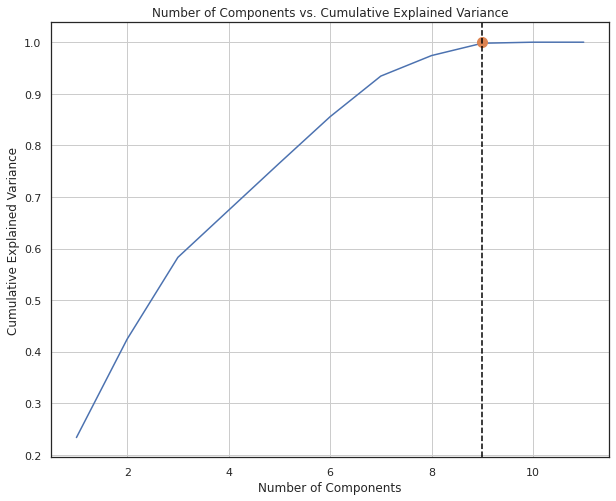

11


In [ ]:
# Visualize Cumulative Explained Variance and select number of features needed
cum_evr_lr = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 8))
plt.plot(np.arange(1, len(cum_evr_lr)+1), cum_evr_lr)
plt.plot(9, cum_evr_lr[9], 'o', ms=10)
# plt.plot(np.arange(1, len(cum_evr_lr)+1), [1.0]*len(cum_evr_lr))
plt.axvline(x = 9, color = 'black', ls='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Number of Components vs. Cumulative Explained Variance")
plt.grid(True, which="both")
plt.show()
print(len(cum_evr_lr))

We can see from the plot that any more than nine features add no significance to the cumulative explained variance. Hence, we chose nine features to use as our PCA results.

In [ ]:
# PCA for dimension reduction
pca_lr = PCA(n_components = 9)

pca_x_train_sc = pca_lr.fit_transform(x_train_sc)

# The x train/test set with only the ideal 9 components
pca_x_test_sc = pca_lr.transform(x_test_sc)

In [ ]:
# OLS with reduced features
lin_reg_pca = LinearRegression().fit(pca_x_train_sc, y_train_lr)
y_pred_pca_lr = lin_reg_pca.predict(pca_x_test_sc)

corr_coef_pca_lr = r2_score(y_test_lr.values, y_pred_pca_lr)
rmse_pca_lr = np.sqrt(mean_squared_error(y_test_lr.values, y_pred_pca_lr))

print(f'The correlation coefficient R squared is {round(corr_coef_pca_lr, 4)}.')
print(f'The RMSE score is {round(rmse_pca_lr, 4)}.')

The correlation coefficient R squared is 0.6452.
The RMSE score is 5.3351.


We see that the usage of PCA also provides no significant improvement to the model, yielding a similar correlation coefficient and RMSE value to the previous models. This implies that collinearity between the features is not the main cause of the innaccuracy of the linear regression model, and could instead be that the relationship between the features and the nutrition score does not follow a linear trend. More likely than not, the relationship between the two may exhibit some exponential trend, as their may be boundaries for certains features which, when passed, result in a much higher (i.e. worse) nutrition score than the preceding values would result in.

We note, however, that in the boxplots presented previously there were many upper outliers in the features, with some taking very extreme values. While these were still considered valid data, having foods having energy/caloric values of more than 20,000 seems unreasonable, and such extremes affect the linear regression model. Thus, prior to moving on to a different model, we choose to perform outlier replacement by setting a threshold for the features and replacing outliers with this threshold, with aim to discover if the extreme outliers in the data are the top contributors to the innaccuracy.

### Linear Regression with Outlier Replacement

We define the upper threshold for outliers to be a maximum of 20% greater than the upper fence, to allow for some outlier values but to replace extreme ones. In the following cell, we apply this replacement to the dataframe. We show boxplots of the new data below for comparison. 

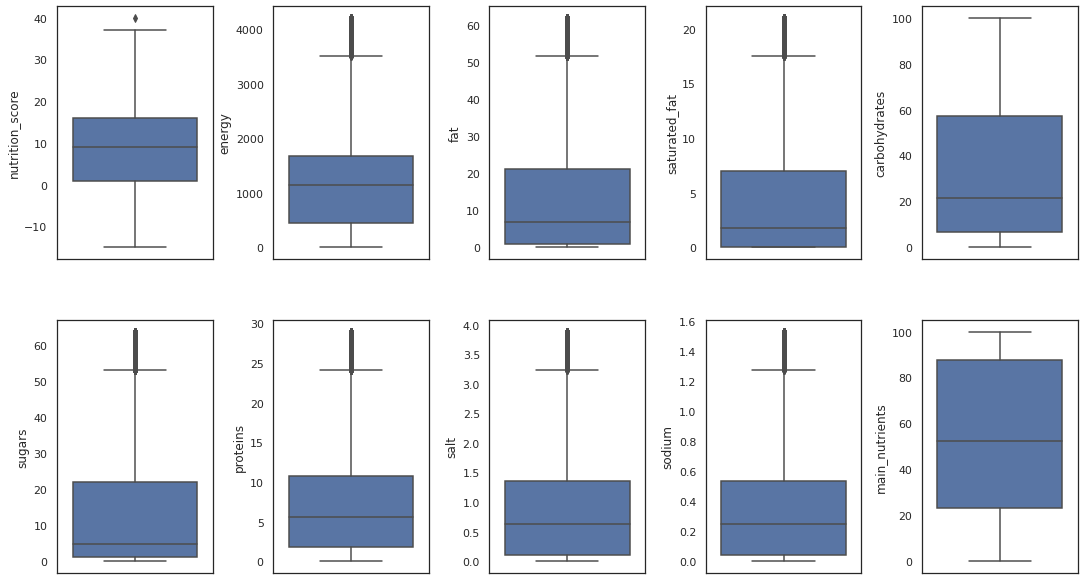

In [ ]:
# Remove outliers
nutrition_mod_df = nutrition_df.copy()

for column in nutrition_mod_df.columns:
  if (column == 'organic' or column == 'diet' or column == 'lite' or column == 'nutrition_score'):
    continue
  q3 = nutrition_mod_df[column].quantile(0.75)
  iqr = q3 - nutrition_mod_df[column].quantile(0.25)
  upper = 1.20 * (q3 + 1.5 * iqr)
  nutrition_mod_df.loc[nutrition_mod_df[column] > upper, column] = upper

# Visualize the distribution of nutrition facts after removing outliers
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(15,8))
index = 0
axs = axs.flatten()
for k,v in nutrition_mod_df.items():
  if (index < 10):
    sns.boxplot(y=k, data=nutrition_mod_df, ax=axs[index])
  index += 1
plt.tight_layout(pad=.4, w_pad=.5, h_pad=5)


The filtered outlier data shows much less skewness due to outliers, as the extreme values now take on more reasonable ones. With this, we now perform linear regression once more. Note that we do not normalize here as unregularized linear regression is scale invariant. 

In [ ]:
# We define the features and the label
score_mod = nutrition_df['nutrition_score']
features_mod = nutrition_mod_df[keep]

# Here we get the train-test split (80-20 as before)
x_train_lr_mod, x_test_lr_mod, y_train_lr_mod, y_test_lr_mod = train_test_split(features_mod, score_mod, test_size = 0.2)


# Here we apply the linear regression model
lin_reg_mod = LinearRegression().fit(x_train_lr_mod, y_train_lr_mod)
y_pred_lr_mod = lin_reg_mod.predict(x_test_lr_mod)

corr_coeff_lr_mod = r2_score(y_test_lr_mod.values, y_pred_lr_mod)
rmse_lr_mod = np.sqrt(mean_squared_error(y_test_lr_mod.values, y_pred_lr_mod))

print(f'The correlation coefficient R squared is {round(corr_coeff_lr_mod, 4)}.')
print(f'The RMSE score is {round(rmse_lr_mod, 4)}, which is about {100*round(rmse_lr_mod/np.mean(score_mod),2)}% of \
the mean nutrition score.')

The correlation coefficient R squared is 0.8378.
The RMSE score is 3.6081, which is about 40.0% of the mean nutrition score.


Here, we see that replacing the outliers significantly improved the result, with the correlation coefficient $R^2$ increasing to almost 84% and the RMSE value decreasing, making it be about 40% of the mean nutrition score. Thus, it seems as though the extreme outlier values in the data were having a significant impact on the linear model. However, a difference of almost 40% from the mean nutrition score indicates that the predictions were still quite innaccurate, and thus we will move on to a random forest model to attempt to better predict nutrition scores. 

## Random Forest for Predicting Nutrition Score

In this section, we will use random forest models to predict nutrition scores. We will use the same inputs as in the linear regression models. We will still use the Root Mean Squared Error (RMSE) and the correlation coefficient $R^2$ to compare prediction results.

First, let's try a random forest regression model with n_estimators of 40 and max_depth of 10.

In [ ]:
# Random Forest baseline
rf_regr = RandomForestRegressor(n_estimators=40, max_depth=10, random_state=0, n_jobs=-1)
rf_regr.fit(x_train_lr, y_train_lr)
y_pred_rf = rf_regr.predict(x_test_lr)
corr_coeff_rf = r2_score(y_test_lr.values, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_lr.values, y_pred_rf))

print(f'The correlation coefficient R squared is {round(corr_coeff_rf, 4)}.')
print(f'The RMSE score is {round(rmse_rf, 4)}, which is about {100*round(rmse_rf/np.mean(score),2)}% of \
the mean nutrition score.')

The correlation coefficient R squared is 0.9322.
The RMSE score is 2.3321, which is about 26.0% of the mean nutrition score.


We can see the results has been improved compared to linear regression models, with the correlation coefficient $R^2$ at 93% and the Root Mean Squared Error (RMSE) around 2.36, which is about 26% of the mean nutrition score. Given that we did not replace any outliers in this case, this is an improvement over linear regression already, albeit still innaccurate.

### Hyperparameter Tuning

Now, we want to further improve the model by changing n_estimators and max_depth.

First, let's try n_estimators from 10 to 201.

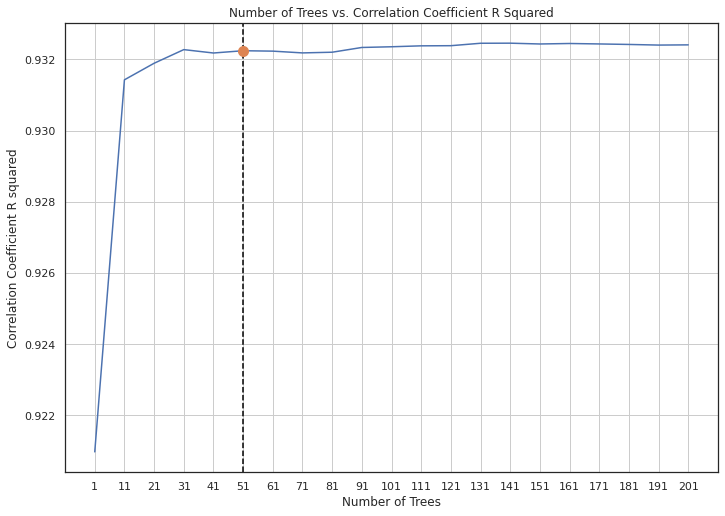

In [ ]:
# Sweep number of estimators
corr_coef_rf_list = []
rmse_rf_list = []
n_est_rf_list = []
for n_est in range(1, 202, 10):
  rf_regr = RandomForestRegressor(n_estimators=n_est, max_depth=10, random_state=0, n_jobs=-1)
  rf_regr.fit(x_train_lr, y_train_lr)
  y_pred_rf = rf_regr.predict(x_test_lr)
  corr_coeff_rf = r2_score(y_test_lr.values, y_pred_rf)
  rmse_rf = np.sqrt(mean_squared_error(y_test_lr.values, y_pred_rf))
  corr_coef_rf_list.append(corr_coeff_rf)
  rmse_rf_list.append(rmse_rf)
  n_est_rf_list.append(n_est)

# Visualize R squared
plt.plot(corr_coef_rf_list)
plt.title('Number of Trees vs. Correlation Coefficient R Squared')
plt.xlabel('Number of Trees')
plt.ylabel('Correlation Coefficient R squared')
plt.xticks(range(0,21), labels=n_est_rf_list)
plt.axvline(x = 5, color = 'black', ls='--')
plt.plot(5, corr_coef_rf_list[5], 'o', ms=10)
plt.grid(True, which='both')

Here, we sweep the number of trees from 1 to 201 with an interval of 10 (20 points in total). The x-axis is the number of trees, while the y-axis is the performance of the corresponding random forest model (by R-squared). 

Based on our results, we chose 51 as our selected parameter of the number of trees, which balances the performance and complexity best. (In general, increasing the number of trees improves the correlation coefficient $R^2$. However, when the number of trees is larger than 51, the improvement is very limited. Considering the model's complexity, it is not worth increasing the number of trees to higher than 51.)


Now, let's use n_estimators of 51 and try max_depth from 2 to 30.

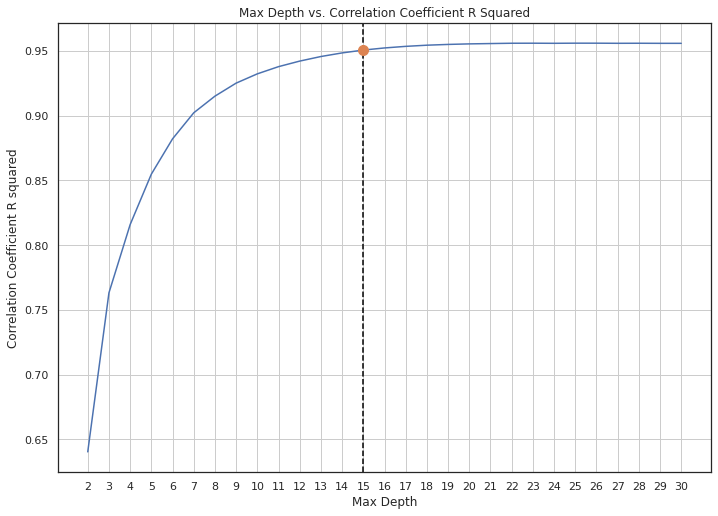

In [ ]:
# Sweep max depth
corr_coef_rf_list = []
rmse_rf_list = []
max_depth_rf_list = []
for max_depth in range(2, 31, 1):
  rf_regr = RandomForestRegressor(n_estimators=51, max_depth=max_depth, random_state=0, n_jobs=-1)
  rf_regr.fit(x_train_lr, y_train_lr)
  y_pred_rf = rf_regr.predict(x_test_lr)
  corr_coeff_rf = r2_score(y_test_lr.values, y_pred_rf)
  rmse_rf = np.sqrt(mean_squared_error(y_test_lr.values, y_pred_rf))
  corr_coef_rf_list.append(corr_coeff_rf)
  rmse_rf_list.append(rmse_rf)
  max_depth_rf_list.append(max_depth)

# Visualize R squared
plt.plot(corr_coef_rf_list)
plt.axvline(x = 13, color = 'black', ls='--')
plt.plot(13, corr_coef_rf_list[13], 'o', ms=10)
plt.title('Max Depth vs. Correlation Coefficient R Squared')
plt.xlabel('Max Depth')
plt.ylabel('Correlation Coefficient R squared')
plt.xticks(range(0,29), labels=max_depth_rf_list)
plt.grid(True, which='both')

Here, we sweep the max depth from 2 to 30 (29 points in total). The x-axis is the max depth of trees, while the y-axis is the performance of the corresponding random forest model (by R-squared). 

Based on our results, we chose 15 as our selected parameter of the max depth, which balances the performance and complexity best. (Increasing the max depth improves the correlation coefficient $R^2$. However, when the max depth is larger than 15, the improvement is very limited. Considering the model's complexity, it is not worth increasing the max depth to higher than 15.)

Now, let's create our final Random Forest model using the best n_estimators and max_depth we found in the above tuning process.

In [ ]:
# Use the best parameter picked to build random forest and model the data
rf_regr = RandomForestRegressor(n_estimators=51, max_depth=15, random_state=0, n_jobs=-1)
rf_regr.fit(x_train_lr, y_train_lr)
y_pred_rf = rf_regr.predict(x_test_lr)
corr_coeff_rf = r2_score(y_test_lr.values, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_lr.values, y_pred_rf))

print(f'The correlation coefficient R squared is {round(corr_coeff_rf, 4)}.')
print(f'The RMSE score is {round(rmse_rf, 4)}, which is about {100*round(rmse_rf/np.mean(score),2)}% of \
the mean nutrition score.')

The correlation coefficient R squared is 0.9506.
The RMSE score is 1.9908, which is about 22.0% of the mean nutrition score.


The hyper-tuned Random Forest model improves the correlation coefficient $R^2$ by almost 2%, and the Root Mean Squared Error (RMSE) decreases by a bit over 0.4 compared to the initial Random Forest model.

# Obstacles Encountered

Perhaps one of the biggest obstacles we encountered was sparsity in the data, particularly when it came to the amount of null values present, the meaningful columns in the data, and as a result the number of significant features we could include in our modeling. This is represented in the accuracy of the models we used for nutrition score, which, although improved as we progressed, were still not passable for wide-use. 

Another issue which we encountered was the substantial amount of extreme outliers in the data. While we decided to still consider many of these outliers as valid data for modeling based on the sum of main nutrients, many of the values seem too extreme to be reasonable. However, due to being unable to resample, we were forced to instead perform outlier replacement for these values, modifying the data which generally we would like to avoid. On the other hand, values such as products with more than 100g of salt seem a bit extreme to be true, at least based on serving size, thus the innaccuracy of our models may be dependent on the manner in which users inputted data.


# Conclusion

## EDA

EDA allowed us to answer subqueries about the dataset, as well as determine suitable features to include in our modeling. 

The initial analysis and visualization regarding the differences between France and UK nutrition scores allowed us to determine the label which we would use in our modeling (and further EDA). 

The analysis of product availability in different countries allowed us to determine whether or not this could be used as a feature in modeling, which we determined to be unsuitable as no real correlation betwen availability and nutrition score could be drawn. 

Our analysis of the keywords "diet", "lite", and "organic" proved to be beneficial for our feature selection, as a correlation between the nutrition score of foods and the presence of this keyword was able to be drawn and later incorporated in our modeling.

Our analysis of exploring the relationship between nutrition score and brand characteristics, while we did not end up using the information in the modeling, was nonetheless an interesting question to explore, and our findings indicated the possiblility of a correlation between the two.

Finally, our analysis of nutrients proved to be likely the most beneficial to our feature selection. Here, we selected nutrients which could be deemed as "main nutrients" to include as the primary features in our modeling, which we found greatly correlated with nutrition score. This was expected, as (based on the source provided in the beginning) the nutrition score value depends heavily on the nutrients in the product.


## Models

### Linear Regression

The Linear Regression models for predicting nutrition scores were all quite innaccurate. Prior to replacing outliers, the standard, Lasso regularized, Ridge regularized, and PCA Linear Regression models all demonstrated a correlation coefficient below 65%, and an RMSE value of almost 5.4, which was about 59% of the mean nutrition score. Such a high RMSE value and relatively low correlation coefficient demonstrates innacurracy of the model, which replacing outliers assisted in addressing somewhat but still resulted in innacurate predictions (correlation coefficient of about 83% and RMSE which was about 40% of the mean). The innaccuracy of these models, even with outlier replacement, suggests that the relationship between nutrition scores and the features may not exhibit a purely linear model, as well as that the features possibly underfit the model for prediction of nutrition scores.

### Random Forest Classifiers

Relative to the Linear Regression model, the Random Forest model for predicting nutrition scores performed well, with hypertuning the parameters resulting in a significant increase in the correlation coefficient to nearly 95% and a reduction of the RMSE value to about 20% of the mean nutrition score, all without the need to replace outliers in the data as we did in Linear Regression. We do note, however, that overall this is still not an exceptional model for predicting nutrition score due to the still high RMSE value which points to innaccuracy in the predictions on the test data. We suspect that this innaccuracy may still be present due to a lack of appropriate features in the dataset to include in the model, and perhaps more significantly the drastic outliers in the data which were still considered as valid observations.

# Potential Next Steps



*   The source explaining the calculation of the nutrition score states that the score is based not only on nutrients, but also on more complex data such as manufacturing process, ingredient condition, variety, and more. Using this information, perhaps we could improve our models by finding data which includes information on how certain products are manufactured and the quality of ingredients used in their production. 
  *   This data would likely require some NLP, since complex data such as this would likely not be compiled as simple statistics. At best, these could be extracted and encoded prior to processing, but the latter is more likely.

*   We mentioned before that many outliers in the data seem too extreme to be reasonable, and saw in our modeling that replacing these outliers has a significant effect on the accuracy of the model. Thus, we may be able to more properly handle these outliers in some way.
  *   More likely than not, we could use data from the web to "fact check" these observations, replacing the features of any inconsistent observations with more appropriate ones. This may help improve the model without using such a generalized replacement as we did.
  * This web crawling could also be used to find more information on the products of the open food facts table, providing us with more features for modeling and addressing the scarcity issue we faced.   


